# Crack Size Estimation Pipeline

In [1]:
# Initialization
%load_ext autoreload
%autoreload 2

# Basic imports for file manipulation
import sys
import os
import io
import time
import copy
import pickle
import glob
from copy import deepcopy
# Matrix manipulation library
import numpy as np
# Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import torch.utils.data
# Standard python libraries
import random
import math
# Computer vision libraries for image manipulation
import cv2 as cv 
from PIL import Image
# Seaborn for statistics and plotting 
import seaborn as sns
# For geo spatial dataframes
import geopandas as gpd


# The following are to do with interactive notebook code
%matplotlib inline 
import matplotlib
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import matplotlib.patches as patches
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

print(f"OpenCV Version: {cv.__version__}")
plt.ion()   # interactive mode

dtype = torch.float
ltype = torch.long
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print('Torch using device:', device)


OpenCV Version: 4.2.0
Torch using device: cuda:0


## Blyncsy Data Visualization

In [2]:
blyncsy_data_path = '/cs6945share/blyncsy_data'
blyncsy_images_path = os.path.join(blyncsy_data_path, 'udot/sample1/images')
blyncsy_geojson_path = os.path.join(blyncsy_data_path, 'udot/sample1/sample1.geojson')

blyncsy_image_filepaths = [os.path.join(blyncsy_images_path, f) for f in sorted(os.listdir(blyncsy_images_path))]

724


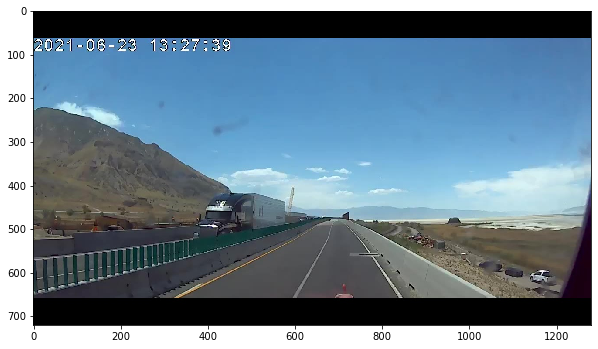

77


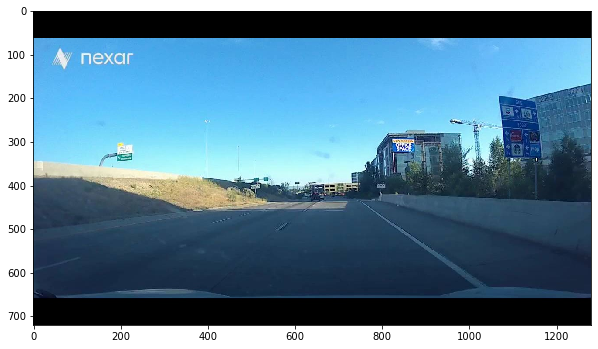

811


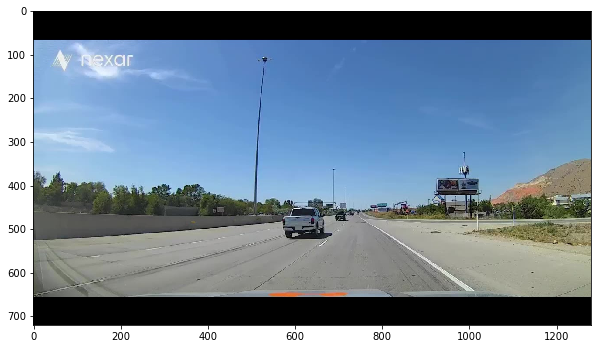

927


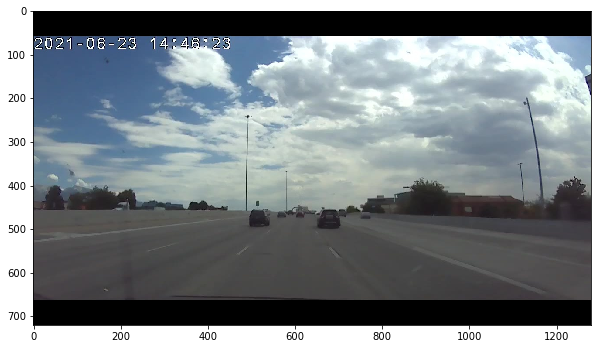

1261


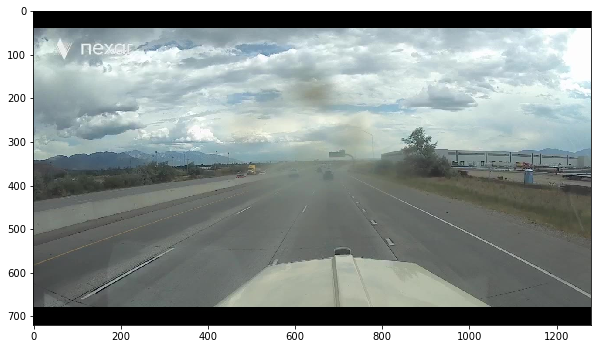

539


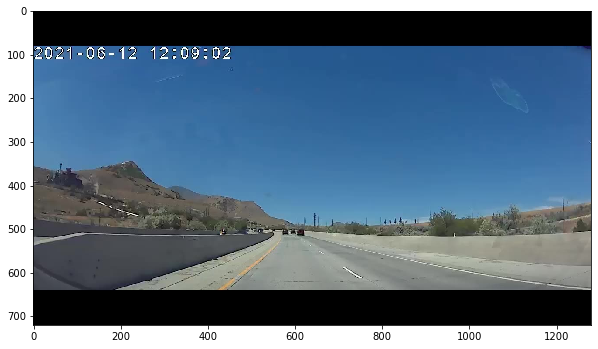

1070


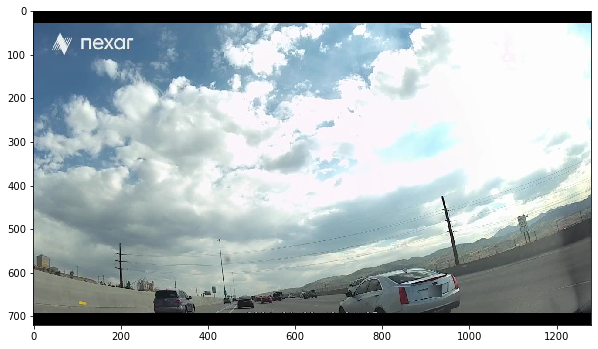

940


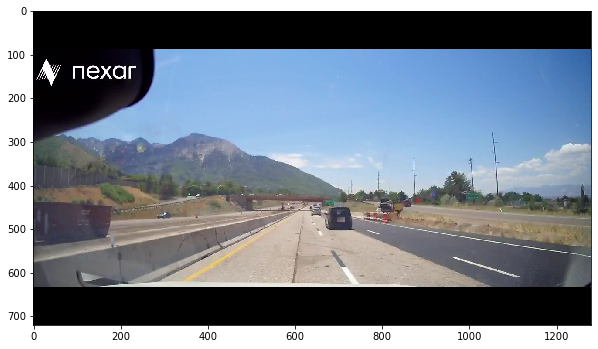

1115


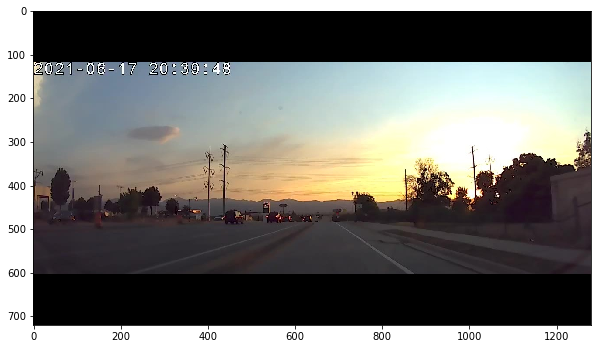

427


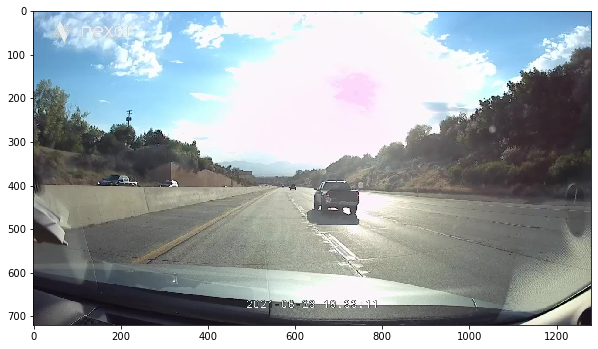

395


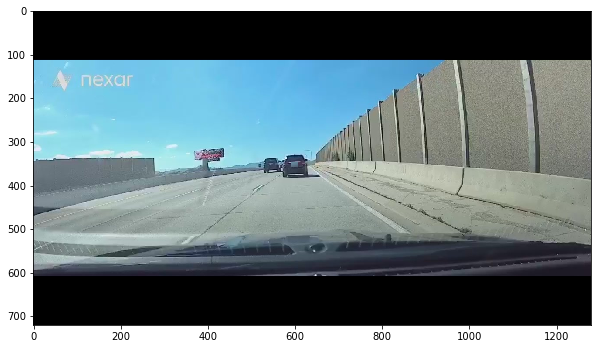

833


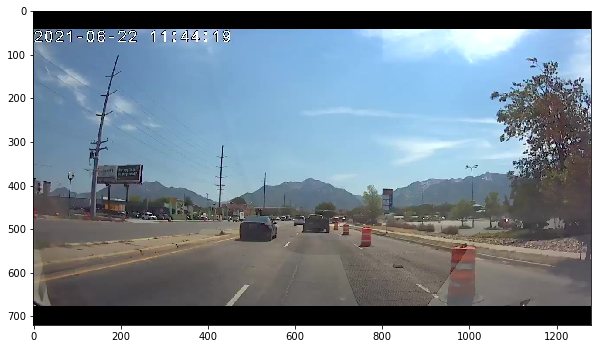

232


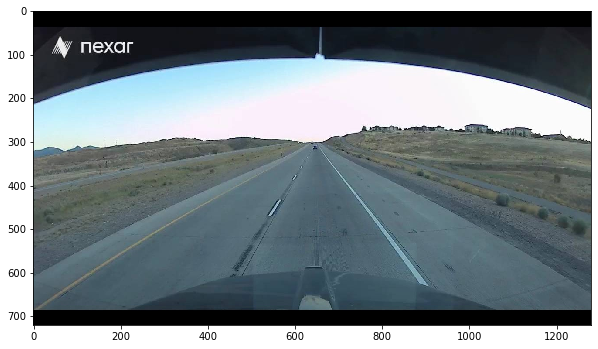

1312


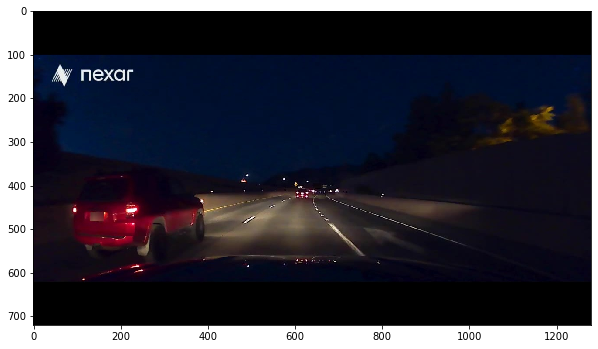

7


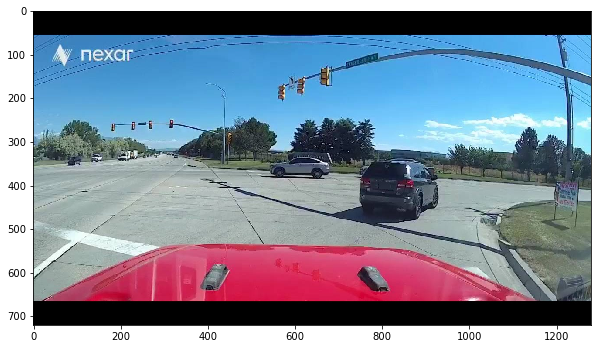

516


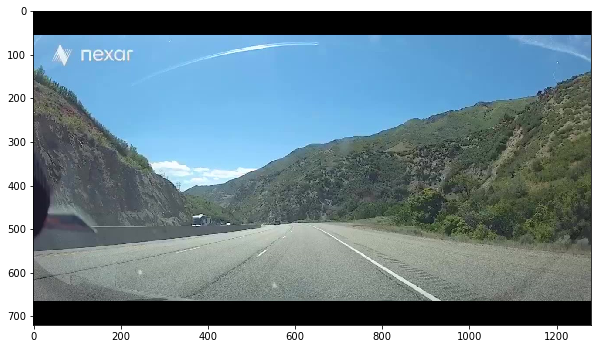

1220


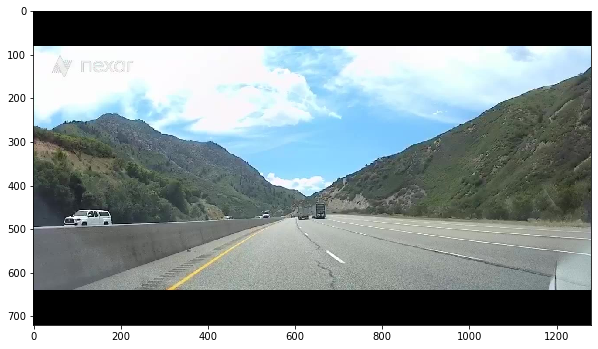

954


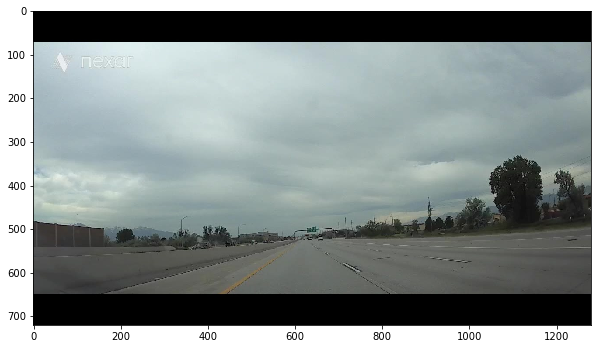

407


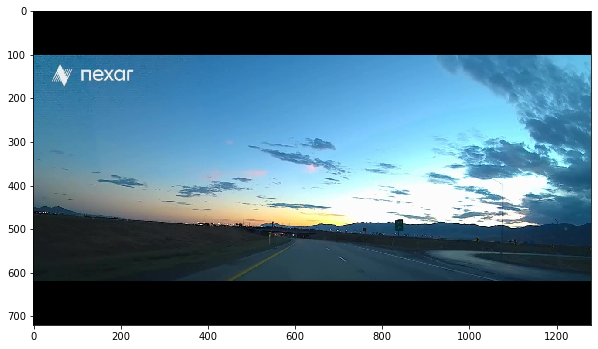

1263


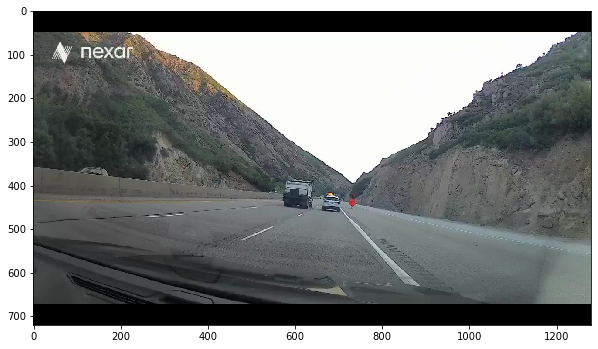

In [3]:
r = random.choices(list(range(len(blyncsy_image_filepaths))), k=20)
for i in r:
    print(i)
    plt.figure()
    plt.imshow(plt.imread(blyncsy_image_filepaths[i]))
    plt.show()

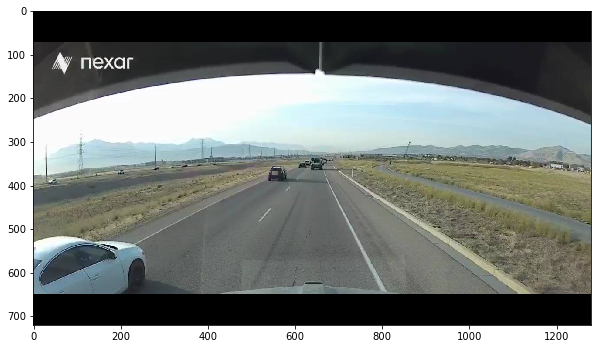

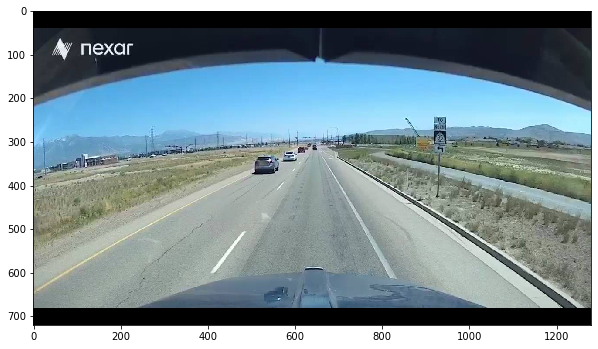

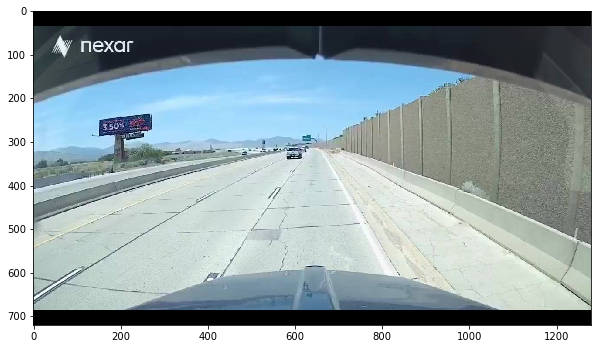

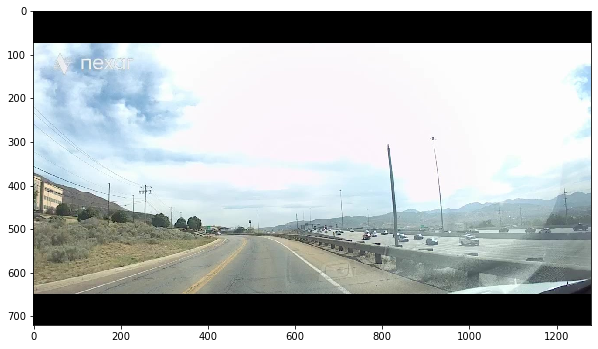

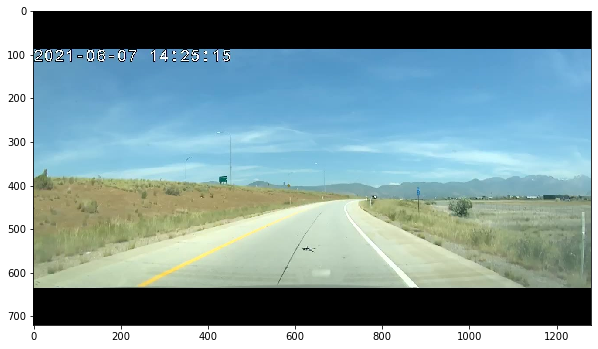

In [4]:
plt.figure()
plt.imshow(plt.imread(blyncsy_image_filepaths[155]))
plt.show()
plt.figure()
plt.imshow(plt.imread(blyncsy_image_filepaths[264]))
plt.show()
plt.figure()
plt.imshow(plt.imread(blyncsy_image_filepaths[286]))
plt.show()
plt.figure()
plt.imshow(plt.imread(blyncsy_image_filepaths[526]))
plt.show()
plt.figure()
plt.imshow(plt.imread(blyncsy_image_filepaths[1148]))
plt.show()

## General Utility Functions

In [5]:
def insert_to_path_if_necessary(path):
    if path not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print("Updated Python Path")

In [6]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [7]:
def extract_images_from_video(vid_path, vid_extract_start_ms, vid_extract_end_ms, skip_num=1, preview=True, preview_and_save=False):
    extracted_image_list = []
    vid = cv.VideoCapture(vid_path)
    i = 0
    while vid.isOpened():
        image_exists, image = vid.read()
        current_ms = vid.get(cv.CAP_PROP_POS_MSEC)
        if (current_ms < vid_extract_start_ms):
            continue
        if (current_ms > vid_extract_end_ms):
            break
        if not image_exists:
            continue
        i += 1
        if i != skip_num:
            continue
        i = 0
        image_color_conv = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        extracted_image_list.append(image_color_conv)
        if preview:
            plt.figure()
            plt.title('Image timestamp = {0}ms'.format(current_ms))
            plt.imshow(image_color_conv)
            if preview_and_save:
                save_path = os.path.join(os.getcwd(),'img_{0}.png'.format(current_ms))
                cv.imwrite(save_path, image)
                print('Saved image to {0}'.format(save_path))
            plt.show()
    vid.release()
    return extracted_image_list

In [8]:
def plot_p1_p2_collection(vid_image, p1_collection, p2_collection):
    plt.figure()
    plt.imshow(vid_image)
    for p1,p2 in zip(p1_collection, p2_collection):
        color = np.random.rand(3,)
        plt.plot(p1[0], p1[1], c=color, marker='.')
        plt.plot(p2[0], p2[1], c=color, marker='x')
    plt.show()

# # e.g.
# p1_collection = np.array([[598, 1024], [865, 1120]]) # Denoted as .
# p2_collection = np.array([[742, 1003], [965, 1073]]) # Denoted as x

def plotting_points_of_interest(fig, ax1, ax2, p1_collection, p2_collection, evaluation_results, ax1_title_text=None, ax2_title_text=None):
    legend_list = []
    for i,(p1,p2) in enumerate(zip(p1_collection, p2_collection)):
        predicted_distances, ground_truth, difference = evaluation_results
        color = np.random.rand(3,)
        ax1.plot(p1[0], p1[1], c=color, marker='.')
        ax1.plot(p2[0], p2[1], c=color, marker='x')
        ax2.plot(p1[0], p1[1], c=color, marker='.')
        ax2.plot(p2[0], p2[1], c=color, marker='x')
        patch = patches.Patch(color=color, label='Predicted distances pred dist = {0}m, GT = {1}m, diff={2}m'.format(predicted_distances[i], ground_truth[i], difference[i]))
        legend_list.append(patch)
    ax1.legend(handles=legend_list)
    ax2.legend(handles=legend_list)
    if ax1_title_text is not None:
        ax1.set_title(ax1_title_text)
    if ax2_title_text is not None:
        ax2.set_title(ax2_title_text)

def ada_bins_evalaute_against_ground_truth(dmap, ground_truth, p1_collection, p2_collection):
    dmap_array = np.array(dmap)
    predicted_distances = []
    for i,(p1,p2) in enumerate(zip(p1_collection, p2_collection)):
        predicted_distance = np.abs(dmap_array[tuple(p2)] - dmap_array[tuple(p1)])
        predicted_distances.append(predicted_distance)
        
    predicted_distances_arr = np.array(predicted_distances)
    difference = predicted_distances_arr - ground_truth
    return predicted_distances_arr, ground_truth, difference


In [9]:
def viz_boxes(pil_img, list_tup_bbox, n_classes=6):
    plt.figure()
    plt.imshow(np.array(pil_img))
    cmap = get_cmap(n_classes, name='hsv_r')
    for tup_bbox in list_tup_bbox:
        bb, cls, prob = tup_bbox 

        color = cmap(cls)
        x_min, y_min, x_max, y_max = bb
        # bb is [x_min, y_min, x_max, y_max]
        width = x_max-x_min
        height = y_max-y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x_max-18, y_max, cls, fontweight='heavy', color=color)
    plt.show()

def filter_list_tup_bbox(list_tup_bbox, prob_thresh):
    filtered_list_tup_bbox = []
    for tup_bbox in list_tup_bbox:
        bb, cls, prob = tup_bbox 
        if prob < prob_thresh:
            continue
        filtered_list_tup_bbox.append(tup_bbox)
    return filtered_list_tup_bbox

# Naive Size Estimation Approach

Monocular Image -> (YOLO/FasterRCNN) -> Bounding Boxed Cracks -> (AdabBins), (LaneDetector) -> Depth Map, Detected Lane -> Crack Estimated Dimensions


Will naively estimate the "height" of crack as difference in depth between the top and bottom depth values of the bounding box. (Can mess with exactly what depth values are used, e.g. an average over the top and an average over bottom depth values etc.)

Will naively estimate the "width" of a crack in terms of the lane width (ratio of width of crack bounding box to the width of the lane) then given a lane size of the road can give the "width" of the crack.

## Crack Detection

### FasterRCNN

In [10]:
fasterrcnn_src_root = '../adithya_models/models'


### FasterRCNN Prediction Utility Functions

In [11]:
# a "list_tup_bbox" is a list of tupes containing tuples of bounding boxes of [x_min, y_min, x_max, y_max], a classification, and a probability/softmax output for the classification
def pil_to_FasterRCNN_input_tensor(pil_img, device):
    img_arr = np.asarray(pil_img, dtype="float")/255
    FasterRCNN_input_tensor = torch.unsqueeze(torch.tensor(img_arr, device=device).movedim(2,0).float(),0)
    return FasterRCNN_input_tensor

def FasterRCNN_output_to_list_tup_bbox(out_full):
    out = out_full[0]
    boxes = out['boxes'].cpu().detach().numpy()
    labels = out['labels'].cpu().detach().numpy()
    scores = out['scores'].cpu().detach().numpy()
    list_tup_bbox = []
    for b,l,s in zip(boxes, labels, scores):
        list_tup_bbox.append((b,l,s))
    return list_tup_bbox

def FasterRCNN_predict_pil_images_anysize(model, pil_images, device, filtering_threshold=0.3):
    filtered_list_tup_bbox_list = []
    for pil_image in pil_images:
        image_tensor = pil_to_FasterRCNN_input_tensor(pil_image, device)
        out = model(image_tensor)
        list_tup_bbox = FasterRCNN_output_to_list_tup_bbox(out)
        filtered_list_tup_bbox = filter_list_tup_bbox(list_tup_bbox, filtering_threshold)
        filtered_list_tup_bbox_list.append(filtered_list_tup_bbox)
    return filtered_list_tup_bbox_list

## Monocular Depth Estimation

### AdaBins

In [12]:
# AdaBins Monocular Depth for Monocular Depth Estimation
adabins_src_root = './AdaBins'
insert_to_path_if_necessary(adabins_src_root)
from models.unet_adaptive_bins import UnetAdaptiveBins
from model_io import load_checkpoint

Updated Python Path


### AdaBins Prediction Utillity Functions

In [13]:
def adabins_predict(model, image_tensor, device, min_depth, max_depth):
    bins, pred = model(image_tensor)
    pred = np.clip(pred.cpu().numpy(), min_depth, max_depth)

    # Flip
    flip_image_tensor = torch.Tensor(np.array(image_tensor.cpu().numpy())[..., ::-1].copy()).to(device)
    pred_lr = model(flip_image_tensor)[-1]
    pred_lr = np.clip(pred_lr.cpu().numpy()[..., ::-1], min_depth, max_depth)

    # Take average of original and mirror
    final = 0.5 * (pred + pred_lr)
    final = nn.functional.interpolate(torch.Tensor(final), image_tensor.shape[-2:],mode='bilinear', align_corners=True).cpu().numpy()

    final[final < min_depth] = min_depth
    final[final > max_depth] = max_depth
    final[np.isinf(final)] = max_depth
    final[np.isnan(final)] = min_depth

    centers = 0.5 * (bins[:, 1:] + bins[:, :-1])
    centers = centers.cpu().squeeze().numpy()
    centers = centers[centers > min_depth]
    centers = centers[centers < max_depth]

    return centers, final

def adabins_predict_pil_anysize(model, normalizer, pil_image, prediction_dimensions, device, min_depth, max_depth):
    original_size = pil_image.size
    pil_image_resize = pil_image.resize(prediction_dimensions)
    image_resize = np.asarray(pil_image_resize) / 255.
    image_tensor = normalizer(torch.from_numpy(image_resize.transpose((2, 0, 1)))).unsqueeze(0).float().to(device)
    bin_centers, predicted_depth = adabins_predict(model, image_tensor, device, min_depth, max_depth)
    dmap_pred = predicted_depth[0][0]
    dmap_pred_upsample = Image.fromarray(dmap_pred).resize(original_size) # Performs bicubic interpolation
    return dmap_pred_upsample

def adabins_predict_pil_images_anysize(model, pil_images, prediction_dimensions, device, min_depth, max_depth):
    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    dmaps = []
    for pil_image in pil_images:
        dmaps.append(adabins_predict_pil_anysize(model, normalizer, pil_image, prediction_dimensions, device, min_depth, max_depth))
    return dmaps

def adabins_viz(pil_image, dmap_pred, extra_plotting_func=None, cbar_min=None, cbar_max=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,5))

    ax1.imshow(pil_image)
    ax1.set_title('Monocular Dashcam Image')

    sns.heatmap(dmap_pred, cmap=sns.color_palette("Spectral_r", as_cmap=True), square=True, ax=ax2, vmin=cbar_min, vmax=cbar_max)
    ax2.set_title('AdaBins Predicted Depth Map (in meters)')
    
    if extra_plotting_func is not None:
        extra_plotting_func(fig, ax1, ax2)
    
    ax1.set_yticks([],[])
    ax1.set_xticks([],[])
    ax2.set_yticks([],[])
    ax2.set_xticks([],[])
    fig.tight_layout()
    fig.show()
    plt.show()


In [14]:
# test_adabins_images = [Image.open(blyncsy_image_filepaths[0]), Image.open(blyncsy_image_filepaths[1]), Image.open(blyncsy_image_filepaths[2])]

# from models.unet_adaptive_bins import UnetAdaptiveBins
# from model_io import load_checkpoint


# min_depth = 1e-3
# max_depth = 80
# model = UnetAdaptiveBins.build(n_bins=256, min_val=min_depth, max_val=max_depth)
# model, _, _ = load_checkpoint('./AdaBins/pretrained/AdaBins_kitti.pt', model)
# model.eval()
# model = model.to(device)

# with torch.no_grad():
#     dmaps = adabins_predict_pil_images_anysize(model, test_adabins_images, (1241, 376), device, min_depth, max_depth)
#     for img,dmap in zip(test_adabins_images,dmaps):
#         adabins_viz(img, dmap, extra_plotting_func=None, cbar_min=None, cbar_max=None)
        
        

## Lane Detection


### LaneDet
Open source lane detection toolbox based on PyTorch that aims to pull together a wide variety of state-of-the-art lane detection models: https://github.com/Turoad/lanedet
- It was found that there are some incompatibilities with the GPU because of the required pytorch verison, this can be kind of forced to work but I am unsure about the resulting performance

### PINet

In [15]:
PINet_src_root = './PINet_new/TuSimple'
insert_to_path_if_necessary(PINet_src_root)
from hourglass_network import lane_detection_network
from parameters import Parameters

Updated Python Path


### PINet Utility Functions

In [16]:
def eliminate_fewer_points(x, y):
    # eliminate fewer points
    out_x = []
    out_y = []
    for i, j in zip(x, y):
        if len(i)>2:
            out_x.append(i)
            out_y.append(j)     
    return out_x, out_y   
def generate_result(confidance, offsets,instance, p):
    mask = confidance > p.threshold_point

    grid = p.grid_location[mask]
    offset = offsets[mask]
    feature = instance[mask]

    lane_feature = []
    x = []
    y = []
    for i in range(len(grid)):
        if (np.sum(feature[i]**2))>=0:
            point_x = int((offset[i][0]+grid[i][0])*p.resize_ratio)
            point_y = int((offset[i][1]+grid[i][1])*p.resize_ratio)
            if point_x > p.x_size or point_x < 0 or point_y > p.y_size or point_y < 0:
                continue
            if len(lane_feature) == 0:
                lane_feature.append(feature[i])
                x.append([point_x])
                y.append([point_y])
            else:
                flag = 0
                index = 0
                min_feature_index = -1
                min_feature_dis = 10000
                for feature_idx, j in enumerate(lane_feature):
                    dis = np.linalg.norm((feature[i] - j)**2)
                    if min_feature_dis > dis:
                        min_feature_dis = dis
                        min_feature_index = feature_idx
                if min_feature_dis <= p.threshold_instance:
                    lane_feature[min_feature_index] = (lane_feature[min_feature_index]*len(x[min_feature_index]) + feature[i])/(len(x[min_feature_index])+1)
                    x[min_feature_index].append(point_x)
                    y[min_feature_index].append(point_y)
                elif len(lane_feature) < 12:
                    lane_feature.append(feature[i])
                    x.append([point_x])
                    y.append([point_y])
                
    return x, y

def sort_along_y(x, y):
    out_x = []
    out_y = []

    for i, j in zip(x, y):
        i = np.array(i)
        j = np.array(j)

        ind = np.argsort(j, axis=0)
        out_x.append(np.take_along_axis(i, ind[::-1], axis=0).tolist())
        out_y.append(np.take_along_axis(j, ind[::-1], axis=0).tolist())
    
    return out_x, out_y

def draw_points(x, y, image, p):
    color_index = 0
    for i, j in zip(x, y):
        color_index += 1
        if color_index > 12:
            color_index = 12
        for index in range(len(i)):
            image = cv.circle(image, (int(i[index]), int(j[index])), 10, p.color[color_index], -1)
    return image


### Mapping from PINet Output (Lane Line Points) to Lane Lines Utility Functions

- Clustering can be problematic for getting lane lines from lane line points since points from different lines are often clustered together. It was then necessary to perform linear regression on the clusters to get lines.

- Linear regression can be problematic for getting lane lines from lane line points since outlier points can greatly effect the line. This also meant that it was necessary to rely on the classification of lane lines by PINet (or clustering) (unlike the hough transform which I just made PINet output all points as the same class then found lines directly) which I found to be inconsitent and highly dependent on the PINet prediction parameters.


In [17]:
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from skimage.transform import hough_line, hough_line_peaks,probabilistic_hough_line
from skimage.feature import canny
from skimage.color import rgb2gray
from matplotlib import cm


def get_lane_lines_linear_regression(x, y, y_min_max_tup=None):
    line_parameters_list = []
    for i, j in zip(x, y):
        x_arr = np.array(i).reshape(-1, 1)
        y_arr = np.array(j)
        if y_min_max_tup is not None:
            selected_idxs = np.logical_and(y_arr>y_min_max_tup[0], y_arr<y_min_max_tup[1])
            x_arr = x_arr[selected_idxs]
            y_arr = y_arr[selected_idxs]
            if not x_arr.size > 0:
                continue


#         cluster_arr = np.array((i,j)).T
#         # Compute DBSCAN
#         cluster_arr_norm = StandardScaler().fit_transform(cluster_arr)
#         db = DBSCAN(eps=0.3, min_samples=2).fit(cluster_arr_norm)
#         core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#         core_samples_mask[db.core_sample_indices_] = True
#         labels = db.labels_
#         # Number of clusters in labels, ignoring noise if present.
#         n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#         n_noise_ = list(labels).count(-1)
#         unique_labels = set(labels)
    
    
        model = LinearRegression().fit(x_arr, y_arr)  
        line_parameters_list.append((model.coef_.item(),model.intercept_.item()))
    return line_parameters_list

def get_lane_lines_hough_transform(x, y, lane_img_shape, y_min_max_tup=None, line_abs_slope_min_cutoff=1e-5, line_abs_slope_max_cutoff=10000, ht_peaks_min_distance=200, ht_peaks_min_angle=30, ht_peaks_threshold=100):
    line_parameters_list = []
    for i, j in zip(x, y):
        x_arr = np.array(i).reshape(-1, 1)
        y_arr = np.array(j)
        if y_min_max_tup is not None:
            selected_idxs = np.logical_and(y_arr>y_min_max_tup[0], y_arr<y_min_max_tup[1])
            x_arr = x_arr[selected_idxs]
            y_arr = y_arr[selected_idxs]
            if not x_arr.size > 0:
                continue
        background = np.zeros(lane_img_shape)
        for index in range(len(y_arr)):
            background = cv.circle(background, (int(x_arr[index,0]), int(y_arr[index])), 10, (255,255,255), -1)
        background = rgb2gray(background)
#         plt.figure()
#         plt.imshow(background, cmap=cm.gray)
        h, theta, d = hough_line(background)
        for accum, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=ht_peaks_min_distance, min_angle=ht_peaks_min_angle, threshold=ht_peaks_threshold)):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - lane_img_shape[1] * np.cos(angle)) / np.sin(angle)
#             plt.plot((0, lane_img_shape[1]), (y0, y1), '-r')
            m = (y1-y0)/lane_img_shape[1]
            # Continue if slope doesn't meet constraints
            if np.abs(m) < line_abs_slope_min_cutoff or np.abs(m) > line_abs_slope_max_cutoff:
                continue
            b = y0
            line_parameters_list.append((m,b))
#         plt.show()

    return line_parameters_list

### PINet Prediction Utility Functions

In [18]:
def PINet_predict_pil_anysize(pin_model, pil_img, device, PINet_params, give_result_image=False):
    # PINet input should be:
#     sample_batch_size = 1
#     channel = 3
#     height = 256
#     width = 512
#     dummy_input = torch.randn(sample_batch_size, channel, height, width)
    img_arr = np.array(pil_img)
    orig_xy_dims = tuple(reversed(img_arr.shape[:2])) # Flip dims to be in "xy" order
    new_xy_dims = (512, 256)
    pil_img_resize = pil_img.resize(new_xy_dims)
    img_arr_resize = np.asarray(pil_img_resize, dtype="float")/255
    PINet_input_tensor = torch.unsqueeze(torch.tensor(img_arr_resize, device=device).movedim(2,0).float(),0)
    
    torch.cuda.synchronize()
    outputs, features = pin_model(PINet_input_tensor)
    confidences, offsets, instances = outputs[-1]     

    confidence = confidences[0].view(PINet_params.grid_y, PINet_params.grid_x).cpu().data.numpy()

    offset = offsets[0].cpu().data.numpy()
    offset = np.rollaxis(offset, axis=2, start=0)
    offset = np.rollaxis(offset, axis=2, start=0)
        
    instance = instances[0].cpu().data.numpy()
    instance = np.rollaxis(instance, axis=2, start=0)
    instance = np.rollaxis(instance, axis=2, start=0)

    # generate point and cluster
    raw_x, raw_y = generate_result(confidence, offset, instance, PINet_params)

    # eliminate fewer points
    in_x, in_y = eliminate_fewer_points(raw_x, raw_y)
                
    # sort points along y 
    in_x, in_y = sort_along_y(in_x, in_y)  
    

    # rescale in_x and in_y to be on original image dimensions
    scale_factor_x = orig_xy_dims[0]/new_xy_dims[0]
    scale_factor_y = orig_xy_dims[1]/new_xy_dims[1]
    
    scale_in_x = [[int(j*scale_factor_x) for j in i] for i in in_x]
    scale_in_y = [[int(j*scale_factor_y) for j in i] for i in in_y]
    
    if give_result_image:
        result_image = draw_points(scale_in_x, scale_in_y, deepcopy(img_arr), PINet_params)
        return scale_in_x, scale_in_y, result_image

    return scale_in_x, scale_in_y

def PINet_predict_pil_images_anysize(pin_model, pil_images, device, PINet_params, give_result_images=False, y_min_max_tup=None, line_abs_slope_min_cutoff=0.1, line_abs_slope_max_cutoff=100, ht_peaks_min_distance=200, ht_peaks_min_angle=30, ht_peaks_threshold=170):
    lane_detect_result_image_list = []
    lane_lines_list = []
    for pil_image in pil_images:
        if give_result_images:
            in_x, in_y, lane_detect_result_image = PINet_predict_pil_anysize(pin_model, pil_image, device, PINet_params, give_result_image=True)
            lane_detect_result_image_list.append(lane_detect_result_image)
        else:
            in_x, in_y = PINet_predict_pil_anysize(pin_model, pil_image, device, PINet_params, give_result_image=False)
        
        image_shape = np.array(pil_image).shape
        lane_lines = get_lane_lines_hough_transform(in_x, in_y, image_shape, y_min_max_tup=y_min_max_tup, line_abs_slope_min_cutoff=line_abs_slope_min_cutoff, line_abs_slope_max_cutoff=line_abs_slope_max_cutoff, ht_peaks_min_distance=ht_peaks_min_distance, ht_peaks_min_angle=ht_peaks_min_angle, ht_peaks_threshold=ht_peaks_threshold)
        lane_lines_list.append(lane_lines)
    if give_result_images:
        return lane_lines_list, lane_detect_result_image_list
    return lane_lines_list

### Experimenting with Methods of Fitting Lane Lines to Lane Points

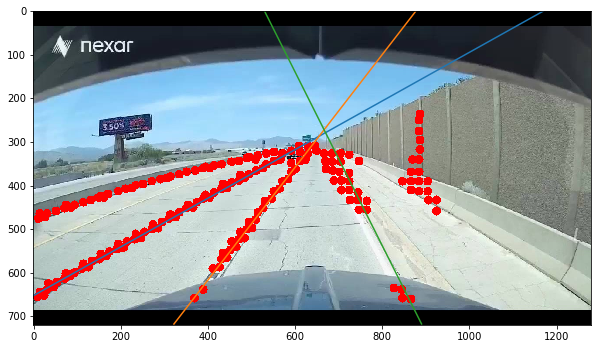

In [19]:
test_blyncsy_image_filepath = blyncsy_image_filepaths[286]
# test_blyncsy_image_filepath = blyncsy_image_filepaths[155]
# test_blyncsy_image_filepath = blyncsy_image_filepaths[526]
# test_blyncsy_image_filepath = blyncsy_image_filepaths[524]
# test_blyncsy_image_filepath = blyncsy_image_filepaths[1148]

test_blyncsy_pil_image = Image.open(test_blyncsy_image_filepath)
PINet_p = Parameters()
PINet_p.threshold_point = 0.1
PINet_p.threshold_instance = 1 # Set this to 1 so hough transform determines line instances
pin_model = lane_detection_network().to(device)
pin_state_dict = torch.load(os.path.join(PINet_src_root, 'savefile/0_tensor(0.5242)_lane_detection_network.pkl'))
pin_model.load_state_dict(pin_state_dict)
with torch.no_grad():
    pin_model.eval()
    in_x, in_y, lane_detect_result_image = PINet_predict_pil_anysize(pin_model, test_blyncsy_pil_image, device, PINet_p, give_result_image=True)

# plt.figure()
# plt.imshow(lane_detect_result_image)
# lane_lines = get_lane_lines_linear_regression(in_x,in_y, y_min_max_tup=(400, lane_detect_result_image.shape[0]-1))
# x_vals = np.arange(lane_detect_result_image.shape[1], dtype=np.int)
# for line in lane_lines:
#     y_vals = line[0]*x_vals + line[1]
#     idx_in_range = np.logical_and(y_vals < lane_detect_result_image.shape[0]-1, y_vals > 0)
#     plt.plot(x_vals[idx_in_range], y_vals[idx_in_range])
# plt.show()

plt.figure()
plt.imshow(lane_detect_result_image)
lane_lines = get_lane_lines_hough_transform(in_x,in_y,lane_detect_result_image.shape,  y_min_max_tup=(400, lane_detect_result_image.shape[0]-1), line_abs_slope_min_cutoff=0.1, line_abs_slope_max_cutoff=100, ht_peaks_min_distance=100, ht_peaks_min_angle=30, ht_peaks_threshold=100)
x_vals = np.arange(lane_detect_result_image.shape[1], dtype=np.int)
for line in lane_lines:
    y_vals = line[0]*x_vals + line[1]
    idx_in_range = np.logical_and(y_vals < lane_detect_result_image.shape[0]-1, y_vals > 0)
    plt.plot(x_vals[idx_in_range], y_vals[idx_in_range])
plt.show()

## Perspective Transform of Bounding Boxes
Image Space -> World Space

The output unit in world space should solely be determined by the units of the depth map. Let me know if this makes sense:

Given the first equation here:

https://stackoverflow.com/questions/31265245/extracting-3d-coordinates-given-2d-image-points-depth-map-and-camera-calibratio

Focal length is in pixels thus the depth determines the world space output units:

https://gamedev.stackexchange.com/questions/166993/interpreting-focal-length-in-units-of-pixels

https://stackoverflow.com/questions/16329867/why-does-the-focal-length-in-the-camera-intrinsics-matrix-have-two-dimensions

In [20]:
def svd(A,b):
  #print(A)
  #print(b.shape)
  try:
     u,s,vh = np.linalg.svd(A)
  except:
      print("non_invertable")
      empty_np = np.zeros(10)
      return empty_np
  inver_s = np.zeros((vh.shape[0],u.shape[0]))
  for i in range(len(s)):
    inver_s[i][i] = 1/s[i]
    if inver_s[i][i] > 9999999:
        inver_s[i][i] = 0

  inverse_A = np.matmul(np.matrix.transpose(vh) ,np.matmul(inver_s, np.matrix.transpose(u)))
  #print(inverse_A)
  #print(b.shape)
  x = np.matmul(inverse_A,b)
  return x

# conrtol_point2D is N*3 (x,y,depth), return 3 list (x,y,z)
# return x_list[N], y_list [N], z_list[N]
def inv_perspective_transform_from_control_point2D(control_point2D, Perspective_matrix):
  x_3d_list = []
  y_3d_list = []
  z_3d_list = []

  for i in range(len(control_point2D)):
    #2d = P*3d, x will be 4d, b will be 3d
    temp_3d = []
    temp_3d.append(control_point2D[i][0]) # x in image2d
    temp_3d.append(control_point2D[i][1]) # y in image2d
    temp_3d.append(control_point2D[i][2]) # depth value in imag
    x = svd(Perspective_matrix,np.array(temp_3d))
    # x will be a 4d point, represnt for x,y,z,w(homogenous coordinate)
    # But if camera is the center, x[3] will always be zero
    x_3d_list.append(x[0])
    y_3d_list.append(x[1])
    z_3d_list.append(x[2])
  return x_3d_list,y_3d_list,z_3d_list

# Will give a list of tuples where each tuple corresponds to bbox and within it has 4 tuples ((top left xyz), (top right xyz), (bottom left xyz), (bottom right xyz)) of x y z points of the bounding box corners
def inv_perspective_transform(bbox_list_image_coords, dmap_arr, Perspective_matrix):
    bbox_list_world_coords = []
    for tup in bbox_list_image_coords:
        (x_min, y_min, x_max, y_max), _, _ = tup
        control_point2D = [[int(x_min), int(y_min), dmap_arr[int(y_min)-1,int(x_min)-1]],[int(x_max), int(y_min), dmap_arr[int(y_min)-1,int(x_max)-1]], [int(x_min), int(y_max), dmap_arr[int(y_max)-1,int(x_min)-1]], [int(x_max), int(y_max), dmap_arr[int(y_max)-1,int(x_max)-1]]]
        for i in range(len(control_point2D)):  
            control_point2D[i][0]*=control_point2D[i][2] # (I think this follows in spirit to this: https://towardsdatascience.com/inverse-projection-transformation-c866ccedef1c)-> cam_coords = K_inv @ pixel_coords * depth.flatten() -> Think similar triangles (focal length/depth proportional to pixel size on sensor/actual size (for each x and y)
            control_point2D[i][1]*=control_point2D[i][2] # (Multiplying pixel x or y by then dividing by focal length (essentially happening in inverse perspective transform) and assuming no skew etc. will essentially recover info to get a 3d points from 2d pixels)
        control_point2D = np.array(control_point2D)

        x_3d_list,y_3d_list,z_3d_list = inv_perspective_transform_from_control_point2D(control_point2D, Perspective_matrix)    
        bbox_list_world_coords.append(((x_3d_list[0],y_3d_list[0],z_3d_list[0]), (x_3d_list[1],y_3d_list[1],z_3d_list[1]), (x_3d_list[2],y_3d_list[2],z_3d_list[2]), (x_3d_list[3],y_3d_list[3],z_3d_list[3])))
    return bbox_list_world_coords

Loading base model ()...

Using cache found in /home/default/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


/usr/lib/python3/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


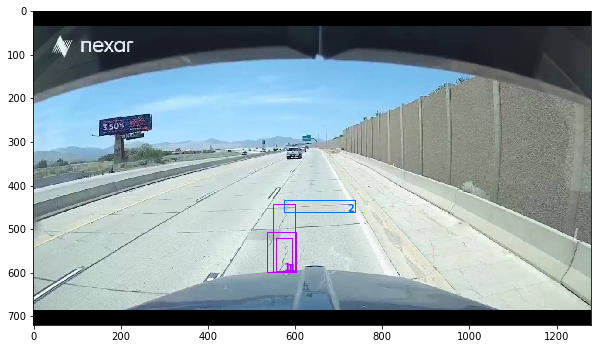

(array([555.1364 , 520.8942 , 592.43005, 596.0953 ], dtype=float32), 1, 0.54595983)
Top width = 0.524065043645586m
Bottom width = 0.3817226702277985m
--------


(array([549.76605, 443.15106, 599.6326 , 597.8617 ], dtype=float32), 1, 0.4335182)
Top width = 1.0887688751606461m
Bottom width = 0.5200939905688786m
--------


(array([536.4278 , 506.95288, 602.70374, 597.5827 ], dtype=float32), 1, 0.34004873)
Top width = 1.001027443902192m
Bottom width = 0.6966465196283371m
--------


(array([573.7908 , 434.002  , 737.28516, 460.11032], dtype=float32), 2, 0.31203735)
Top width = 3.691989804404919m
Bottom width = 3.0912969810974857m
--------




In [21]:
# FasterRCNN
fasterrcnn_model = torch.load(os.path.join(fasterrcnn_src_root, 'v31-training-full_full.pth'))
fasterrcnn_model = fasterrcnn_model.to(device)
fasterrcnn_model.eval()

# AdaBins
adabins_model = UnetAdaptiveBins.build(n_bins=256, min_val=1e-3, max_val=80)
adabins_model, _, _ = load_checkpoint(os.path.join(adabins_src_root, 'pretrained/AdaBins_kitti.pt'), adabins_model)
adabins_model = adabins_model.to(device)
adabins_model.eval()

# P is a 3*3 camera Intrinsic Matrix
IntrinsicMatrix = [722.7379,0,0,0,726.1398,0,663.8862,335.0579,1] 
IntrinsicMatrix = np.reshape(IntrinsicMatrix,(3,3))

# Elements in IntrinsicMatrix: [fx,0,cx,0,fy,cy,0,0,1]
IntrinsicMatrix = np.transpose(IntrinsicMatrix)

# Extrinsic Matrix, we assume the camera is (0,0,0). So the matrix is identity + [0,0,0] translation
ExtrinsicMatrix = [1,0,0,0,0,1,0,0,0,0,1,0]
ExtrinsicMatrix = np.reshape(ExtrinsicMatrix,(3,4))

# print(IntrinsicMatrix)
# print(ExtrinsicMatrix)

Perspective_matrix = np.matmul(IntrinsicMatrix,ExtrinsicMatrix)
# print(Perspective_matrix)

test_idx = 286
test_img = Image.open(blyncsy_image_filepaths[test_idx])
with torch.no_grad():
    test_bboxes = FasterRCNN_predict_pil_images_anysize(fasterrcnn_model, [test_img], device, filtering_threshold=0.3)[0]
    test_dmap = adabins_predict_pil_images_anysize(adabins_model, [test_img], (1241, 376), device, 1e-3, 80)[0]
test_dmap_arr = np.array(test_dmap)

viz_boxes(test_img, test_bboxes)

test_bboxes_world_space = inv_perspective_transform(test_bboxes, test_dmap_arr, Perspective_matrix)

for box_world_space, box_image_space in zip(test_bboxes_world_space, test_bboxes):
    print(box_image_space)
    print('Top width = {0}m'.format(box_world_space[1][0]-box_world_space[0][0]))
    print('Bottom width = {0}m'.format(box_world_space[3][0]-box_world_space[2][0]))
    print('--------\n\n')


## Pipeline

### Size Estimation Utility Functions

In [22]:
def sample_dmap_along_line(dmap_arr, coord1_min, coord1_max, coord2_const, coord1_samples):
    coord1 = np.round(np.linspace(coord1_min, coord1_max-1, num=coord1_samples)).astype(int)
    coord2 = np.full(coord1.shape, np.round(coord2_const)).astype(int)
    points = np.stack((coord1, coord2),axis=-1)
    dvals = dmap_arr[points[:,1],points[:,0]]
    return dvals

# Will return a -1 value for a width if it cannot be found using this method
def lane_width_crack_size_estimation(list_tup_bbox, lane_lines, lane_img_shape, lane_width_m=3, y_min_max_tup=None):
    width_estimation_list = []
    width_estimation_lane_lines_list = []

    # a "list_tup_bbox" is a list of tupes containing tuples of bounding boxes of [x_min, y_min, x_max, y_max], a classification, and a probability/softmax output for the classification
    for tup in list_tup_bbox: # For each bounding box
        (x_min, y_min, x_max, y_max), cls, prob = tup  
        
        # Width estimation
        x_mid = round((y_min+y_max)/2)
        y_mid = round((y_min+y_max)/2)
        
        skip_bbox = False
        # If bounding box is out of y_min_max_tup range then we won't try to get the depth
        if y_min_max_tup is not None and ((y_mid < y_min_max_tup[0]) or (y_mid > y_min_max_tup[1])):
            skip_bbox = True
        
        left_lane_line_x = None
        left_line = None
        right_lane_line_x = None
        right_line = None
#         print("x_min:{0}, x_max:{1}".format(x_min, x_max))
        for line in lane_lines:
            if skip_bbox:
                break
            x = (y_mid-line[1])/line[0]
#             print(line[0])
#             print(x)
            if (x < 0) or (x>lane_img_shape[1]): # shape[1] is x
                # The x is not on the image, skip this lane line
                continue
            # Now know that x is on image x domain
            if x < x_min:
                if left_lane_line_x is None or x > left_lane_line_x:
                    left_lane_line_x = x
                    left_line = line
            elif x > x_max:
                if right_lane_line_x is None or x < right_lane_line_x:
                    right_lane_line_x = x
                    right_line = line
            else: # x>=x_min and x<=x_max
                # lane goes through bbox, consider these lines automatically the closest to either 
                if x>=x_mid:
                    right_lane_line_x = x
                    right_line = line
                else: # x<x_mid
                    left_lane_line_x = x
                    left_line = line     
#             print("l is: {0}, r is {1}\n\n".format(left_lane_line_x, right_lane_line_x))
        lane_width_px = None
        if (left_lane_line_x is None) or (right_lane_line_x is None) or skip_bbox:
            width_estimation_list.append(-1) # Could not find two lines to give lane width
            width_estimation_lane_lines_list.append(None)
        else:
            lane_width_px = right_lane_line_x - left_lane_line_x
            bbox_width_px = x_max - x_min
            bbox_width_in_terms_of_lane_width = bbox_width_px/lane_width_px
            bbox_width_m = bbox_width_in_terms_of_lane_width * lane_width_m
            width_estimation_list.append(bbox_width_m)
            width_estimation_lane_lines_list.append((left_line, right_line))
        
    return width_estimation_list, width_estimation_lane_lines_list

# Get height and width of a crack (width estimated using inverse perspective transform and also by using lane width)
# Will return a -1 value for a height or width if it cannot be found using this method
def crack_size_estimation(list_tup_bbox, dmap, lane_lines, lane_img_shape, Perspective_matrix, top_bottom_height_estimation_samples=5, y_min_max_tup=None, lane_width_m=3):
    dmap_arr = np.array(dmap)
    
    # Width estimation using lane width
    width_estimation_using_lanes_list, width_estimation_lane_lines_list = lane_width_crack_size_estimation(list_tup_bbox, lane_lines, lane_img_shape, lane_width_m=lane_width_m, y_min_max_tup=y_min_max_tup)
    
    # Width estimation using inverse perspective transform with assumed camera parameters
    width_estimation_using_inv_perspective_list = []
    list_tup_bbox_world_coords = inv_perspective_transform(list_tup_bbox, dmap_arr, Perspective_matrix)
    for box_world_space in list_tup_bbox_world_coords:
        top_width = box_world_space[1][0]-box_world_space[0][0]
        bottom_width = box_world_space[3][0]-box_world_space[2][0]
        # Will use average of top and bottom widths as the ground truth
        width_estimation_using_inv_perspective_list.append((top_width+bottom_width)/2)

    # Height estimation using depth difference
    height_estimation_list = []
    for tup in list_tup_bbox: # For each bounding box
        (x_min, y_min, x_max, y_max), cls, prob = tup 
        top_dvals = sample_dmap_along_line(dmap_arr, x_min, x_max, y_max, top_bottom_height_estimation_samples) # m
        bottom_dvals = sample_dmap_along_line(dmap_arr, x_min, x_max, y_min, top_bottom_height_estimation_samples) # m
        height_estimation_m = np.abs(np.mean(top_dvals) - np.mean(bottom_dvals)) # m
        height_estimation_list.append(height_estimation_m)
    
    return height_estimation_list, width_estimation_using_inv_perspective_list, width_estimation_using_lanes_list, width_estimation_lane_lines_list 


    

### Pipeline Visualization Utility Functions

In [23]:
def plot_lane_line_in_range(x_vals, line, img_shape, ax, **plot_kwargs):
    y_vals = line[0]*x_vals + line[1]
    idx_in_range = np.logical_and(y_vals < img_shape[0]-1, y_vals > 0)
    ax.plot(x_vals[idx_in_range], y_vals[idx_in_range], **plot_kwargs)
    
# From: https://stackoverflow.com/questions/57316491/how-to-convert-matplotlib-figure-to-pil-image-object-without-saving-image
def fig2img(fig, my_dpi=96):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', transparent=True, dpi=my_dpi, format='png')
    buf.seek(0)
    img = Image.open(buf)
    return img
    
def get_viz_detection_img(pil_img, list_tup_bbox, pred_heights, pred_widths):
    my_dpi = 96
    fig_viz, ax_viz = plt.subplots(constrained_layout=True, figsize=(pil_img.width/my_dpi+500, pil_img.height/my_dpi), dpi=my_dpi)
    img_arr = np.array(pil_img)
    ax_viz.set_axis_off()
    ax_viz.imshow(img_arr)
    cmap = get_cmap(len(list_tup_bbox), name='hsv_r')
    legend_list = []
    for i, tup_bbox in enumerate(list_tup_bbox):
        bb, cls, prob = tup_bbox
        color = cmap(i)
        x_min, y_min, x_max, y_max = bb
        # bb is [x_min, y_min, x_max, y_max]
        width = x_max-x_min
        height = y_max-y_min
        rect_viz = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax_viz.add_patch(rect_viz)
        ax_viz.text(x_max-18, y_max, cls, fontweight='heavy', color=color)
        patch = patches.Patch(color=color, label='Predicted Height = {0:.4f}m\nPredicted Width = {1:.4f}m\n'.format(pred_heights[i], pred_widths[i]))
        legend_list.append(patch)
    ax_viz.legend(handles=legend_list, loc='right', prop={'size': 20}, framealpha=0.1)
    viz_img = fig2img(fig_viz, my_dpi=my_dpi)
    plt.close(fig_viz)
    
    return viz_img

def viz_pipeline(pil_img, list_tup_bbox, dmap, lane_detect_result_image, lane_lines, pred_heights, pred_widths, width_estimation_lane_lines, cbar_min=None, cbar_max=None, **subplots_kwargs):
    lane_detect_result_image_x_vals = np.arange(lane_detect_result_image.shape[1], dtype=np.int)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, **subplots_kwargs)

    img_arr = np.array(pil_img)
    ax1.imshow(img_arr)
    ax1.set_title('Input Image')
    
    ax2.imshow(img_arr)
    cmap = get_cmap(len(list_tup_bbox), name='hsv_r')
    legend_list = []
    for i, tup_bbox in enumerate(list_tup_bbox):
        bb, cls, prob = tup_bbox
        color = cmap(i)
        x_min, y_min, x_max, y_max = bb
        # bb is [x_min, y_min, x_max, y_max]
        width = x_max-x_min
        height = y_max-y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x_max-18, y_max, cls, fontweight='heavy', color=color)
        if width_estimation_lane_lines[i] is not None:
            plot_lane_line_in_range(lane_detect_result_image_x_vals, width_estimation_lane_lines[i][0], lane_detect_result_image.shape, ax2, color=color, alpha=0.7, ls='--')
            plot_lane_line_in_range(lane_detect_result_image_x_vals, width_estimation_lane_lines[i][1], lane_detect_result_image.shape, ax2, color=color, alpha=0.7, ls='--')
        patch = patches.Patch(color=color, label='Predicted Height = {0}m\nPredicted Width = {1}m\n'.format(pred_heights[i], pred_widths[i]))
        legend_list.append(patch)
    ax2.legend(handles=legend_list, loc=(1.04,0))
    ax2.set_title('Size Estimation\ndetected crack bounding boxes and estimated height and width (-1 if unable to detect)\nIf width could be found, the lane lines used for lane width are plotted')
        
    sns.heatmap(dmap, cmap=sns.color_palette("Spectral_r", as_cmap=True), square=True, ax=ax3, vmin=cbar_min, vmax=cbar_max)
#     ax3.set_yticks([],[])
#     ax3.set_xticks([],[])
    ax3.set_title('Adabins Depth Map')
    
    ax4.imshow(lane_detect_result_image)
    for line in lane_lines:
        plot_lane_line_in_range(lane_detect_result_image_x_vals, line, lane_detect_result_image.shape, ax4)
    ax4.set_title('PINet Detected Lane Line Points with Hough Transform Detected Lane Lanes')

    fig.tight_layout()
    fig.show()
    plt.show()
    
def create_width_estimation_prediction(pred_width_using_inv_perspective, pred_width_using_lane_width, inv_perspective_weight=0.5):
    width_estimation_list = []
    for w_invp, w_lane in zip(pred_width_using_inv_perspective, pred_width_using_lane_width):
        if w_lane == -1:
            width_estimation_list.append(w_invp)
        else:
            est = inv_perspective_weight*w_invp + (1-inv_perspective_weight)*w_lane
            width_estimation_list.append(est)
    return width_estimation_list


## "Main" Crack Size Estimation Pipeline Function:

In [24]:
# Assumes all images are same size, likely could modify to take in variable sizes since inference is not per-batch but per-image. In future "tensor-izing" to allow per-batch inference would allow much faster prediction
def full_crack_size_pipeline(pil_images_key_names, pil_images, fasterrcnn_model, adabins_model, pin_model, Perspective_matrix, device, fasterrcnn_filtering_threshold=0.3, show_viz=False):
    crack_size_dict = {}
    viz_images_list = []
    image_shape = np.array(pil_images[0]).shape
    with torch.no_grad():
        filtered_list_tup_bbox_list = FasterRCNN_predict_pil_images_anysize(fasterrcnn_model, pil_images, device, filtering_threshold=fasterrcnn_filtering_threshold)
        dmap_list = adabins_predict_pil_images_anysize(adabins_model, pil_images, (1241, 376), device, 1e-3, 80) # More information an be found in adabins_verify_src
        if show_viz:
            lane_lines_list, lane_detect_result_image_list = PINet_predict_pil_images_anysize(pin_model, pil_images, device, PINet_p, give_result_images=True, y_min_max_tup=(400, image_shape[0]-1), line_abs_slope_min_cutoff=0.1, line_abs_slope_max_cutoff=100, ht_peaks_min_distance=100, ht_peaks_min_angle=30, ht_peaks_threshold=100)
        else:
            lane_lines_list = PINet_predict_pil_images_anysize(pin_model, pil_images, device, PINet_p, give_result_images=False, y_min_max_tup=(400, image_shape[0]-1), line_abs_slope_min_cutoff=0.1, line_abs_slope_max_cutoff=100, ht_peaks_min_distance=100, ht_peaks_min_angle=30, ht_peaks_threshold=100)
        
    for i in range(len(pil_images)):
        pred_heights, pred_width_using_inv_perspective, pred_width_using_lane_width, width_estimation_lane_lines = crack_size_estimation(filtered_list_tup_bbox_list[i], dmap_list[i], lane_lines_list[i], image_shape, Perspective_matrix, top_bottom_height_estimation_samples=5, y_min_max_tup=(400, image_shape[0]-1), lane_width_m=3)    
        pred_widths = create_width_estimation_prediction(pred_width_using_inv_perspective, pred_width_using_lane_width)
        crack_size_dict[pil_images_key_names[i]] = (pred_heights, pred_widths)
        viz_images_list.append(get_viz_detection_img(pil_images[i], filtered_list_tup_bbox_list[i], pred_heights, pred_widths))
        if show_viz:  
            print('Displaying visualization for pil image with key name {0}'.format(pil_images_key_names[i]))
            viz_pipeline(pil_images[i], filtered_list_tup_bbox_list[i], dmap_list[i], lane_detect_result_image_list[i], lane_lines_list[i], pred_heights, pred_widths, width_estimation_lane_lines, cbar_min=0, cbar_max=60, figsize=(40,5))
            print('-----\n')
    return crack_size_dict, viz_images_list

## Pipeline Testing

### Loading Models

In [25]:
# P is a 3*3 camera Intrinsic Matrix
IntrinsicMatrix = [722.7379,0,0,0,726.1398,0,663.8862,335.0579,1] 
IntrinsicMatrix = np.reshape(IntrinsicMatrix,(3,3))

# Elements in IntrinsicMatrix: [fx,0,cx,0,fy,cy,0,0,1]
IntrinsicMatrix = np.transpose(IntrinsicMatrix)

# Extrinsic Matrix, we assume the camera is (0,0,0). So the matrix is identity + [0,0,0] translation
ExtrinsicMatrix = [1,0,0,0,0,1,0,0,0,0,1,0]
ExtrinsicMatrix = np.reshape(ExtrinsicMatrix,(3,4))

Perspective_matrix = np.matmul(IntrinsicMatrix,ExtrinsicMatrix)

# FasterRCNN
fasterrcnn_model = torch.load(os.path.join(fasterrcnn_src_root, 'v31-training-full_full.pth'))
fasterrcnn_model = fasterrcnn_model.to(device)
fasterrcnn_model.eval()

# AdaBins
adabins_model = UnetAdaptiveBins.build(n_bins=256, min_val=1e-3, max_val=80)
adabins_model, _, _ = load_checkpoint(os.path.join(adabins_src_root, 'pretrained/AdaBins_kitti.pt'), adabins_model)
adabins_model = adabins_model.to(device)
adabins_model.eval()

# PINet
PINet_p = Parameters()
PINet_p.threshold_point = 0.1
PINet_p.threshold_instance = 1 # Set this to 1 so hough transform determines line instances
pin_model = lane_detection_network()
pin_model = pin_model.to(device)
pin_state_dict = torch.load(os.path.join(PINet_src_root, 'savefile/0_tensor(0.5242)_lane_detection_network.pkl'))
pin_model.load_state_dict(pin_state_dict)
pin_model.eval()

print('Loaded models')

Loading base model ()...

Using cache found in /home/default/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
Loaded models


In [26]:
# Setup test data
test_blyncsy_pil_images = []
pil_images_key_names = []

# Random images
# pil_images_key_names = random.choices(range(len(blyncsy_image_filepaths)), k=20)
# test_blyncsy_pil_images = [Image.open(blyncsy_image_filepaths[i]) for i in pil_images_key_names]

# Specific images to illustrate functionality
extra_idxs = [286, 41, 264, 939, 178]
for i in extra_idxs:
    test_blyncsy_pil_images.append(Image.open(blyncsy_image_filepaths[i]))
    pil_images_key_names.append(i)

Displaying visualization for pil image with key name 286


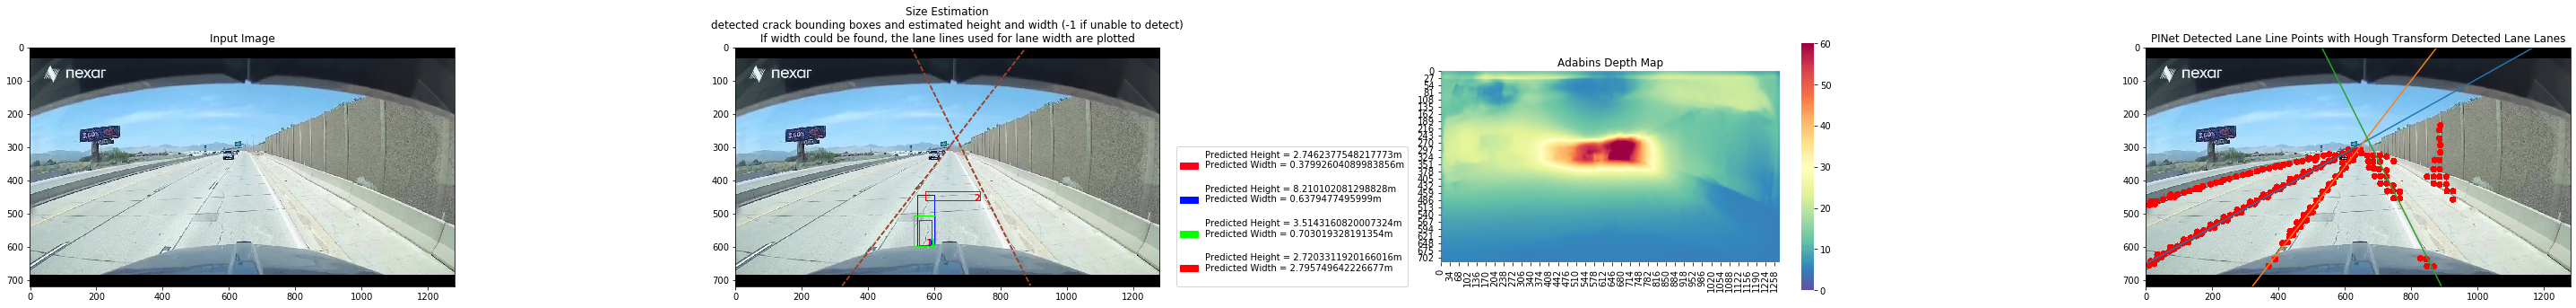

-----

Displaying visualization for pil image with key name 41


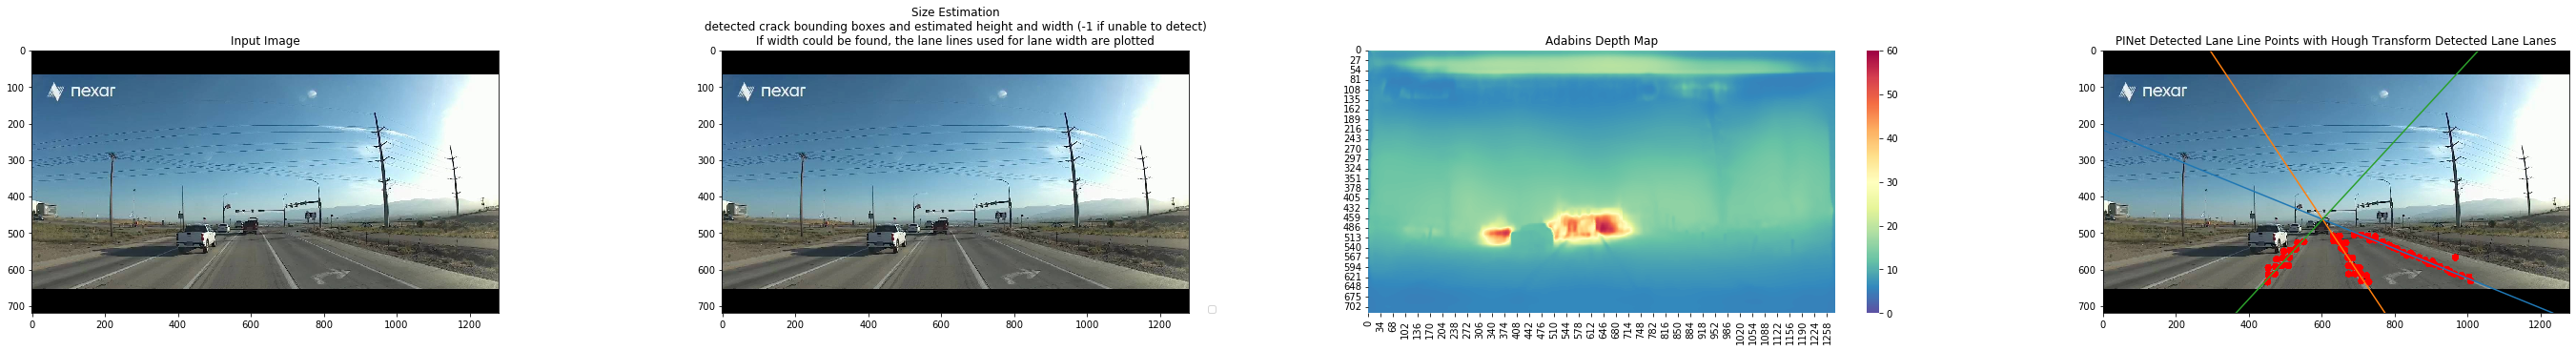

-----

Displaying visualization for pil image with key name 264


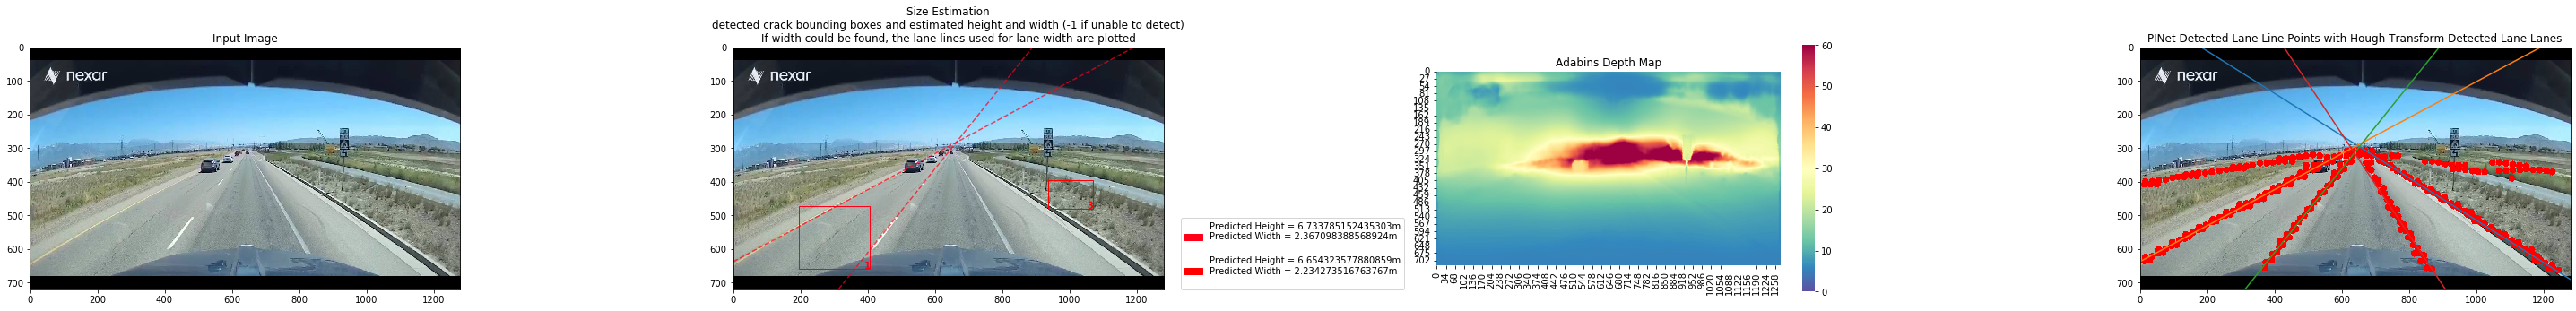

-----

Displaying visualization for pil image with key name 939


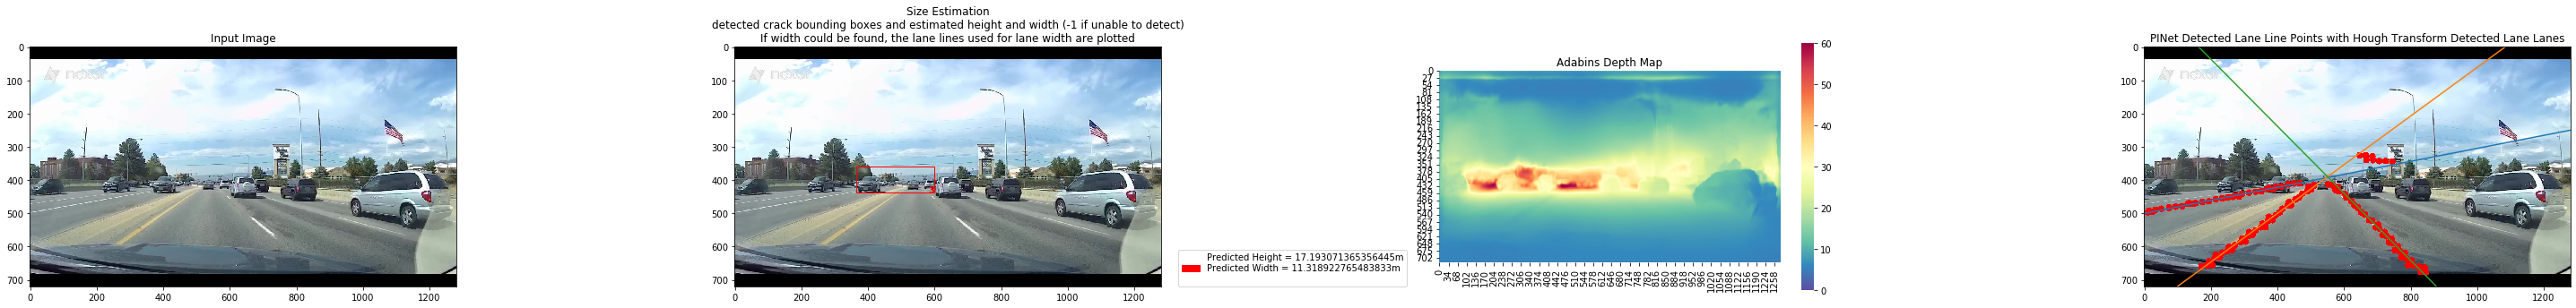

-----

Displaying visualization for pil image with key name 178


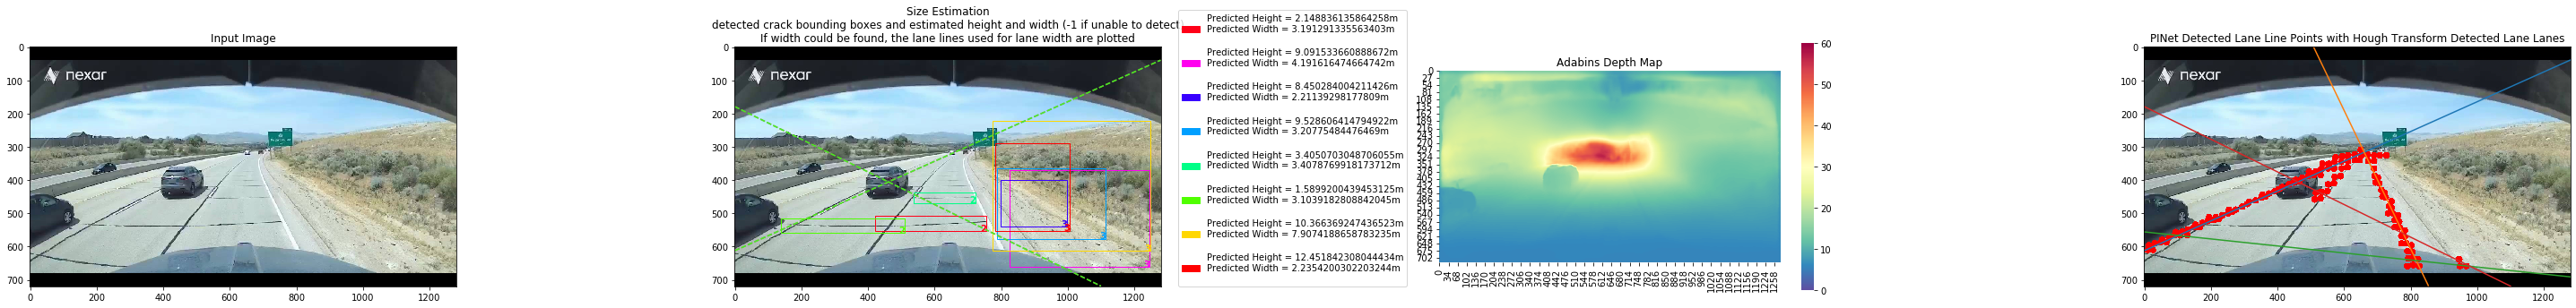

-----



In [27]:
# With viz
crack_size_dict, _ = full_crack_size_pipeline(pil_images_key_names, test_blyncsy_pil_images, fasterrcnn_model, adabins_model, pin_model, Perspective_matrix, device, fasterrcnn_filtering_threshold=0.3, show_viz=True)


{286: ([2.7462378, 8.210102, 3.514316, 2.7203312], [0.37992604089983856, 0.6379477495999, 0.703019328191354, 2.795749642226677]), 41: ([], []), 264: ([6.733785, 6.6543236], [2.367098388568924, 2.234273516763767]), 939: ([17.193071], [11.318922765483833]), 178: ([2.1488361, 9.091534, 8.450284, 9.528606, 3.4050703, 1.58992, 10.366369, 12.451842], [3.191291335563403, 4.191616474664742, 2.21139298177809, 3.20775484476469, 3.4078769918173712, 3.1039182808842045, 7.9074188658783235, 2.2354200302203244])}


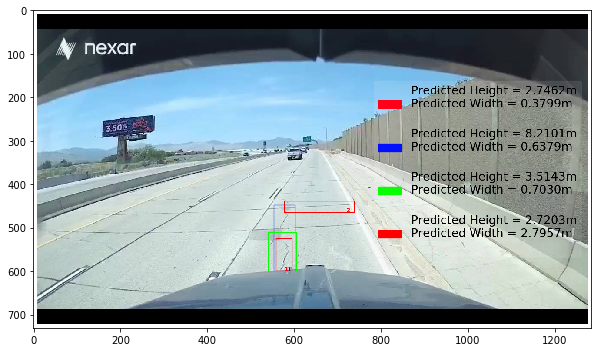

In [28]:
# Without viz
crack_size_dict, test = full_crack_size_pipeline(pil_images_key_names, test_blyncsy_pil_images, fasterrcnn_model, adabins_model, pin_model, Perspective_matrix, device, fasterrcnn_filtering_threshold=0.3, show_viz=False)
print(crack_size_dict)
plt.figure()
plt.imshow(test[0])
plt.show()


## With more time, it would be smart to:
- Not develop in a Jupyter notebook, split the large number of functions into members of modules and classes
- Integrate each part of the pipeline using Pytorch and make each step ready for a batch, this would involve changing some of the post-processing operations to work with tensors but would in turn speed up pipeline and wrapping it in a Pytorch model would give a much quicker pipeline, this should be done once the pipeline is more concrete though. (Currently I am essentially using prediction batch of size 1 for each step of pipeline)
- Transfer learning with AdaBins to get correctly scaled depth for the distribution of Blyncsy images
- Collecting sparse lidar data, cracks size ground truth, and segmented crack data in order to explore more "end-to-end" solutions and segmentation based approaches.


# Crack Size Pipeline "Product"

In [29]:
# Define a function that can be used to generate image tags
def create_im_tag(image_filename, folder_path = "/home/default/workspace/cs6945/data/barrels/images/", ws_prefix = None):
    """Function for creating an html image tag

    This function was designed to be used with a Pandas apply method.

    Parameters
    ----------
    image_filename : str
        a string that is the filename of an image.
    folder_path : str
        a string representing the path to the folder (in the workspace) where 
        images are located. Must end in a forward slash
    ws_prefix : str, optional
        a string representing the workspace prefix (usually the owner's last name).
        Must **not** have a trailing foward slash, e.g. /henderson. If this arg
        is not provided then the function will try to determine it from the 
        environment.
        
    Returns
    -------
    str
        a string representing an HTML element that can show an image
    """
    
    if ws_prefix is None:
        ws_prefix = os.environ["WS_PROXY"]
    s = ws_prefix + "/mini-browser" + folder_path + "/" + image_filename
    html = """ \
        <div style='width:300; height:200'> \
            <a href='{0}' target='_blank' rel='noopener noreferrer'> \
                <img width=100% src='{0}'/> \
            </a> \
        </div>
    """.format(s)
    return html

In [30]:
# Define the input map file
in_map_file = os.path.join(blyncsy_data_path, 'udot/sample1/sample1.geojson')
# Define the product map file
out_map_file = os.path.join(blyncsy_data_path, 'udot/sample1/sample1_crack_size_est.geojson')

# Load the map file into a GeoPandas object
in_map_df = gpd.read_file(in_map_file)

# Take a look at the data
in_map_df

h3_11   index                               dtg     heading  \
0     8b269614cc6efff     702         2021-06-11T21:14:33+00:00    1.100000   
1     8b2696143ae5fff     815  2021-06-06T12:39:48.120998+00:00  173.900000   
2     8b2696a86744fff     898  2021-06-11T21:50:05.598000+00:00  106.432716   
3     8b269606570efff    1511  2021-06-11T23:08:34.028999+00:00  175.971756   
4     8b269606e98afff    1676         2021-06-11T23:22:31+00:00   91.099998   
...               ...     ...                               ...         ...   
2745  8b26961586cefff  905990  2021-06-28T18:49:28.149000+00:00  269.688171   
2746  8b26963adb5afff  906310         2021-06-22T18:08:28+00:00  179.699997   
2747  8b2696055245fff  906973  2021-06-23T19:50:54.745998+00:00    2.700000   
2748  8b269605cd20fff  907111  2021-06-23T21:10:54.745998+00:00  327.600000   
2749  8b269605c024fff  907116  2021-06-23T21:36:34.701000+00:00  145.200000   

                                               sourceId      id  \
0     /home/default/workspace/cs6945share/blyncsy_da...     702   
1     /home/default/workspace/cs6945share/blyncsy_da...     815   
2     /home/default/workspace/cs6945share/blyncsy_da...     898   
3     /home/default/workspace/cs6945share/blyncsy_da...    1511   
4     /home/default/workspace/cs6945share/blyncsy_da...    1676   
...                                                 ...     ...   
2745  /home/default/workspace/cs6945share/blyncsy_da...  905990   
2746  /home/default/workspace/cs6945share/blyncsy_da...  906310   
2747  /home/default/workspace/cs6945share/blyncsy_da...  906973   
2748  /home/default/workspace/cs6945share/blyncsy_da...  907111   
2749  /home/default/workspace/cs6945share/blyncsy_da...  907116   

                         geometry  
0     POINT (-111.94910 40.77540)  
1     POINT (-111.98700 40.77070)  
2     POINT (-111.84330 40.71890)  
3     POINT (-111.95270 40.69840)  
4     POINT (-111.95070 40.66750)  
...                           ...  
2745  POINT (-112.03110 40.72590)  
2746  POINT (-111.89130 40.50480)  
2747  POINT (-112.04600 40.63030)  
2748  POINT (-112.03920 40.61530)  
2749  POINT (-112.03200 40.60590)  

[2750 rows x 7 columns]

In [31]:
sample_file = os.path.join(blyncsy_data_path, 'udot/sample1/sample1_100samples.geojson')
in_map_df.sample(n=100).to_file(sample_file)
# Example of reducing the dataset for testing the code below:
in_map_df = in_map_df.sample(n=100)

In [32]:
# This images folder should have all the images referenced in the in_map_file
in_images_folder = os.path.join(blyncsy_data_path, 'udot/sample1/images')
# The bounding-box (bbox) folder is where annotated images will be placed - it will be created if not exists 
out_images_folder = os.path.join(blyncsy_data_path, "udot/sample1/images_crack_size_est")
os.makedirs(out_images_folder, exist_ok=True)

In [33]:
# Helper function for writing progress to file
def write_barrel_gdf(data_dict, file_path):
    # Create the output GeoDataFrame and write to file
    detect_df = gpd.GeoDataFrame(data_dict, geometry="geometry", crs="EPSG:4326")
    detect_df.to_file(file_path)

# Pull out the sourceIds and prepend endpoint for crack detection images
sourceIds = in_map_df.sourceId
num_ims = len(sourceIds)

# Create a place store detections. This will become the product dataframe
detections = []
pil_images_product = []
crack_size_dict_key_list =[]

print("Getting images from filenames...")
for i, sourceId in enumerate(sourceIds):
    crack_size_dict_key_list.append(os.path.basename(sourceId))
    # Join the image id with the folder location of the input images
    in_im_file = os.path.join(in_images_folder, sourceId)
    # Ensure that the file actually exists
    if os.path.exists(in_im_file):
        img = Image.open(in_im_file).convert("RGB")
        pil_images_product.append(img)
    else:
        print("Could not locate:{0}".format(in_im_file))
print("Done getting images from filenames...")

print("Predicting crack size...")
crack_size_dict, viz_imgs = full_crack_size_pipeline(crack_size_dict_key_list, pil_images_product, fasterrcnn_model, adabins_model, pin_model, Perspective_matrix, device, fasterrcnn_filtering_threshold=0.3, show_viz=False)
print("Done predicting crack size...")

print("Writing to geoJSON...")
for i, (crack_size_dict_key, viz_img) in enumerate(zip(crack_size_dict, viz_imgs)):
    if len(crack_size_dict[crack_size_dict_key][0]) > 0:
        out_im_path = os.path.join(out_images_folder, crack_size_dict_key)
        viz_img.convert('RGB').save(out_im_path)         
        im_data = in_map_df.iloc[i,:].to_dict()
        id = im_data["sourceId"]
        # Generate a new html tag to display the image on the map. The tag that
        # was there previously included the original image location
        im_data["img"] = create_im_tag(crack_size_dict_key, folder_path=out_images_folder)
        # This is also a good place to add additional elements to the infobox
        # Not sure how to do this... would use crack_size_dict (and maybe the bounding box values) to give extra information more dynamically than just having on plot
        detections.append(im_data)
write_barrel_gdf(detections, out_map_file)
print("Done writing to geoJSON...")

print("Done")


Getting images from filenames...
Done getting images from filenames...
Predicting crack size...
Done predicting crack size...
Writing to geoJSON...
Done writing to geoJSON...
Done
